# Rock Paper Scissors Hand Gestures Classification

This notebook contains a model development to classify images of rock, paper, and scissors hand gestures. The model was developed with CNN architecture and trained with [rockpaperscissors](https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip) dataset.

Created by [I Putu Rama Astra Arimbawa](https://www.dicoding.com/users/ramaastra/) as a submission of final project in the 'Belajar Machine Learning untuk Pemula' course on Dicoding.

## Dataset Preparation

### Download & unzip the dataset

In [ ]:
import urllib.request
import zipfile

data_url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
urllib.request.urlretrieve(data_url, 'rps.zip')
local_file = 'rps.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

### Delete unused file & folder

In [ ]:
!rm -r /content/rockpaperscissors/rps-cv-images
!rm /content/rockpaperscissors/README_rpc-cv-images.txt

### Create a variable to store the dataset path

In [ ]:
dataset_dir = '/content/rockpaperscissors'

## Image Processing

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.4,
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = image_datagen.flow_from_directory(dataset_dir,
                                                    subset='training',
                                                    target_size=(150, 150),
                                                    batch_size=64,
                                                    class_mode='categorical')

val_generator = image_datagen.flow_from_directory(dataset_dir,
                                                  subset='validation',
                                                  target_size=(150, 150),
                                                  batch_size=64,
                                                  class_mode='categorical')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## Model Development

In [91]:
import tensorflow as tf

### Define callback for training

In [92]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('acc') > 0.98 and logs.get('val_acc') > 0.98:
      self.model.stop_training = True

In [99]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
  )

In [101]:
accuracy_callback = AccuracyCallback()
callbacks = [accuracy_callback, early_stopping_callback]

### Create the CNN model

In [105]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3, 3), input_shape=(150, 150, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(3, 3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
    ])

  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['acc'])

  return model

In [106]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_15 (Dense)            (None, 128)              

### Train the model

In [107]:
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=val_generator,
                    callbacks=callbacks)

Epoch 1/100
21/21 [==============================] - 20s 833ms/step - loss: 1.1815 - acc: 0.3836 - val_loss: 0.9966 - val_acc: 0.5057
Epoch 2/100
21/21 [==============================] - 17s 827ms/step - loss: 0.9859 - acc: 0.4772 - val_loss: 1.0447 - val_acc: 0.4130
Epoch 3/100
21/21 [==============================] - 21s 1s/step - loss: 0.9310 - acc: 0.5502 - val_loss: 0.8443 - val_acc: 0.6316
Epoch 4/100
21/21 [==============================] - 17s 819ms/step - loss: 0.8329 - acc: 0.6271 - val_loss: 0.7683 - val_acc: 0.6693
Epoch 5/100
21/21 [==============================] - 18s 894ms/step - loss: 0.7471 - acc: 0.7062 - val_loss: 0.6497 - val_acc: 0.7643
Epoch 6/100
21/21 [==============================] - 19s 928ms/step - loss: 0.5927 - acc: 0.7763 - val_loss: 0.5496 - val_acc: 0.7941
Epoch 7/100
21/21 [==============================] - 17s 831ms/step - loss: 0.5198 - acc: 0.8006 - val_loss: 0.4923 - val_acc: 0.7998
Epoch 8/100
21/21 [==============================] - 17s 837ms/st

## Model Evaluation

### Plot the training history

In [108]:
import matplotlib.pyplot as plt

In [109]:
def plot_train_result(history):
  plt.figure(figsize=(12, 4))
  plt.subplots_adjust(top=0.8)
  plt.suptitle(f'Training Result', fontsize=16)

  plt.subplot(1, 2, 1)
  plt.plot(history.history['acc'], label='Train')
  plt.plot(history.history['val_acc'], label='Val')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train')
  plt.plot(history.history['val_loss'], label='Val')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

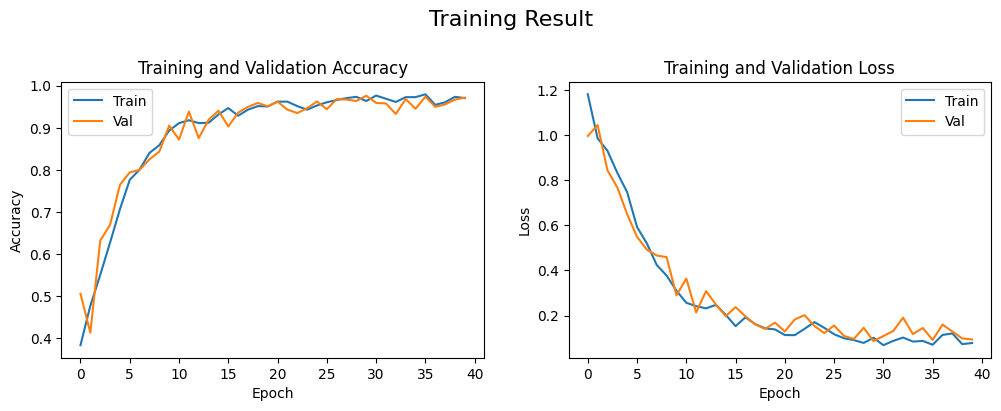

In [110]:
plot_train_result(history)

### Display confusion matrix on the val set

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [112]:
y_true = val_generator.classes

In [113]:
def create_cm():
  predictions = model.predict(val_generator)
  y_pred = np.argmax(predictions, axis=1)

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['Paper', 'Rock', 'Scissors'])

  _, ax = plt.subplots()
  ax.set_title(f'Confusion Matrix on Validation Set')

  disp.plot(ax=ax)

14/14 [==============================] - 7s 464ms/step


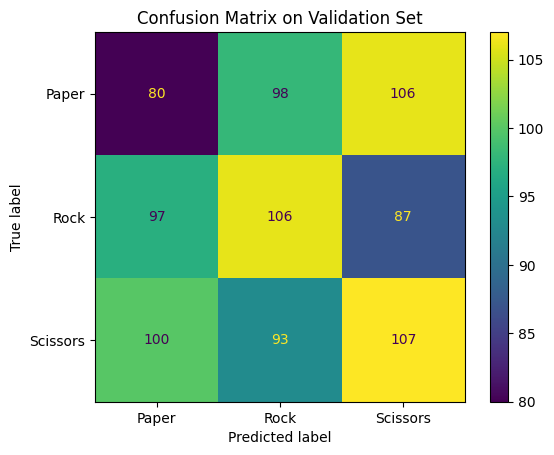

In [114]:
create_cm()

### Test the model predictions on uploaded images

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
from google.colab import files

In [149]:
classes = ['Paper', 'Rock', 'Scissors']

def predict_image(image_path):
  x = load_img(image_path, target_size=(150, 150))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  y = model.predict(x)
  prediction = classes[np.argmax(y)]

  plt.title(f'Predicted as {prediction}')
  plt.imshow(load_img(image_path))

Saving Rock-paper-scissors_(paper).png to Rock-paper-scissors_(paper).png
1/1 [==============================] - 0s 19ms/step


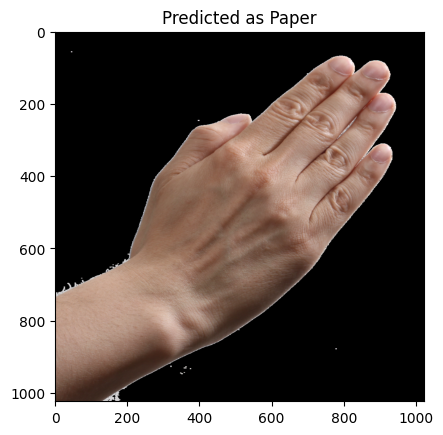

In [152]:
image = files.upload()
image_path = f'/content/{list(image.keys())[0]}'
predict_image(image_path)